In [2]:
#!pip install lime

In [4]:
import os
import sys
import string
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import shutil

from scipy.stats import ttest_ind
from scipy.spatial.distance import cdist

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, SpatialDropout1D, Input, Layer
tf.get_logger().setLevel('ERROR')

import transformers
from transformers import (BertTokenizer, BertModel, TFBertForSequenceClassification, pipeline,
                          DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig)

import torch

import sklearn
from sklearn.utils import shuffle, class_weight
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import classification_report, log_loss, accuracy_score, roc_auc_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/WordsofWar')
from plot_history import plot_training_history
from BertSeqVect import BertSequenceVectorizer

from tqdm import tqdm
tqdm.pandas()

import lime
import lime.lime_tabular

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Print versions
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("nltk:", nltk.__version__)
print("torch:", torch.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:", tf.__version__)
print("transformers:", transformers.__version__)

numpy: 1.25.2
pandas: 2.0.3
nltk: 3.8.1
torch: 2.2.1+cu121
sklearn: 1.2.2
tensorflow: 2.15.0
transformers: 4.40.0


### Train/test split

In [6]:
# Read train, validation, and test sets from CSV files
X_train_df = pd.read_csv('X_train.csv')
X_val_df = pd.read_csv('X_val.csv')
X_test_df = pd.read_csv('X_test.csv')
y_train_df = pd.read_csv('y_train.csv')
y_val_df = pd.read_csv('y_val.csv')
y_test_df = pd.read_csv('y_test.csv')

# Convert DataFrames to numpy arrays
X_train = X_train_df.values
X_val = X_val_df.values
X_test = X_test_df.values
y_train = y_train_df['War'].values
y_val = y_val_df['War'].values
y_test = y_test_df['War'].values

In [7]:
# Determine the input shape
input_shape = (X_train.shape[1:])

---

# MLP

In [7]:
# Define the neural network model
model = Sequential([
    Input(shape=input_shape),
    Dense(128,
          activation='relu',
          input_shape=(768,),
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 106753 (417.00 KB)
Trainable params: 106753 (417.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
opt = SGD(learning_rate=0.001, momentum=0.99, nesterov=True)

# Compile the model
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 3s 11ms/step - loss: 4.5620 - accuracy: 0.5368 - val_loss: 4.4396 - val_accuracy: 0.6050
Epoch 2/10
30/30 [==============================] - 0s 4ms/step - loss: 4.3728 - accuracy: 0.5966 - val_loss: 4.2729 - val_accuracy: 0.6050
Epoch 3/10
30/30 [==============================] - 0s 4ms/step - loss: 4.1640 - accuracy: 0.6355 - val_loss: 4.0194 - val_accuracy: 0.6218
Epoch 4/10
30/30 [==============================] - 0s 4ms/step - loss: 3.9054 - accuracy: 0.6418 - val_loss: 3.7519 - val_accuracy: 0.6471
Epoch 5/10
30/30 [==============================] - 0s 4ms/step - loss: 3.6153 - accuracy: 0.6649 - val_loss: 3.4530 - val_accuracy: 0.6555
Epoch 6/10
30/30 [==============================] - 0s 4ms/step - loss: 3.3304 - accuracy: 0.6649 - val_loss: 3.1656 - val_accuracy: 0.6471
Epoch 7/10
30/30 [==============================] - 0s 4ms/step - loss: 3.0309 - accuracy: 0.6849 - val_loss: 2.8876 - val_accuracy: 0.6639
Epoch 8/10
30/30 [=

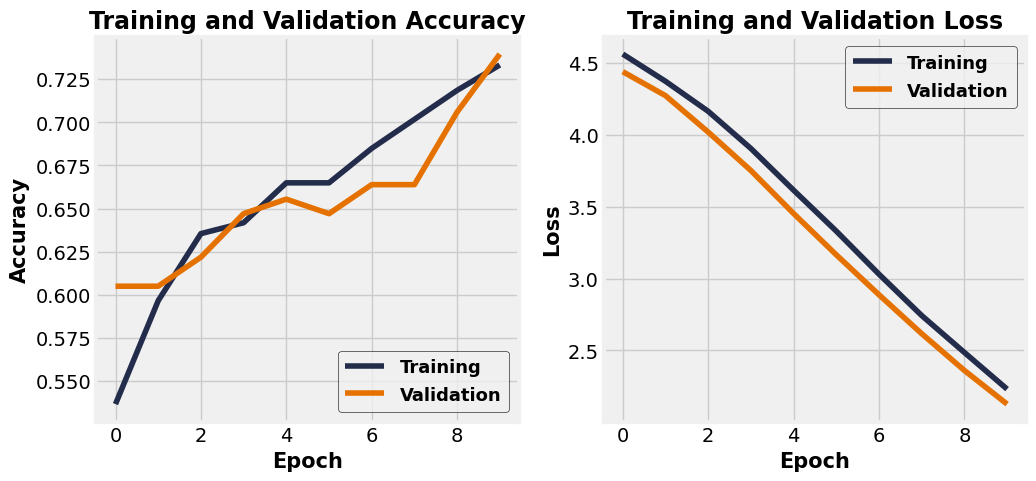

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plot_training_history(acc, val_acc, loss, val_loss, epochs_range)

In [12]:
# Predict probs for positive class
y_pred_prob = model.predict(X_test)

# AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)

# Convert probs to class labels
y_pred_class = (y_pred_prob > 0.5).astype(int)

# F1-score
f1 = f1_score(y_test, y_pred_class)

print("AUC-ROC Score:", auc_roc)
print("F1-Score:", f1)

4/4 [==============================] - 0s 2ms/step
AUC-ROC Score: 0.7693181818181819
F1-Score: 0.48192771084337355


---

# Gated RNN (LSTM)

In [10]:
# Reshape input_shape to add a timestep dimension
input_shape_with_timesteps = (1, input_shape[0])

# Define the neural network model
model2 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1),
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [15]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrap  (None, 1, 768)            0         
 per)                                                            
                                                                 
 lstm (LSTM)                 (None, 128)               459264    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 467585 (1.78 MB)
Trainable params: 467585 (1.78 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [16]:
opt = Adam(learning_rate=0.001)

# Compile the model
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
# Train the model
history2 = model2.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 4s 18ms/step - loss: 1.7363 - accuracy: 0.6324 - val_loss: 1.5137 - val_accuracy: 0.6975
Epoch 2/10
30/30 [==============================] - 0s 7ms/step - loss: 1.3270 - accuracy: 0.7206 - val_loss: 1.2507 - val_accuracy: 0.6303
Epoch 3/10
30/30 [==============================] - 0s 7ms/step - loss: 1.0172 - accuracy: 0.7931 - val_loss: 0.9453 - val_accuracy: 0.7563
Epoch 4/10
30/30 [==============================] - 0s 7ms/step - loss: 0.7870 - accuracy: 0.8382 - val_loss: 0.7799 - val_accuracy: 0.8151
Epoch 5/10
30/30 [==============================] - 0s 7ms/step - loss: 0.6475 - accuracy: 0.8561 - val_loss: 0.6640 - val_accuracy: 0.7815
Epoch 6/10
30/30 [==============================] - 0s 7ms/step - loss: 0.5393 - accuracy: 0.8855 - val_loss: 0.5424 - val_accuracy: 0.8235
Epoch 7/10
30/30 [==============================] - 0s 7ms/step - loss: 0.4370 - accuracy: 0.9128 - val_loss: 0.5084 - val_accuracy: 0.8067
Epoch 8/10
30/30 [=

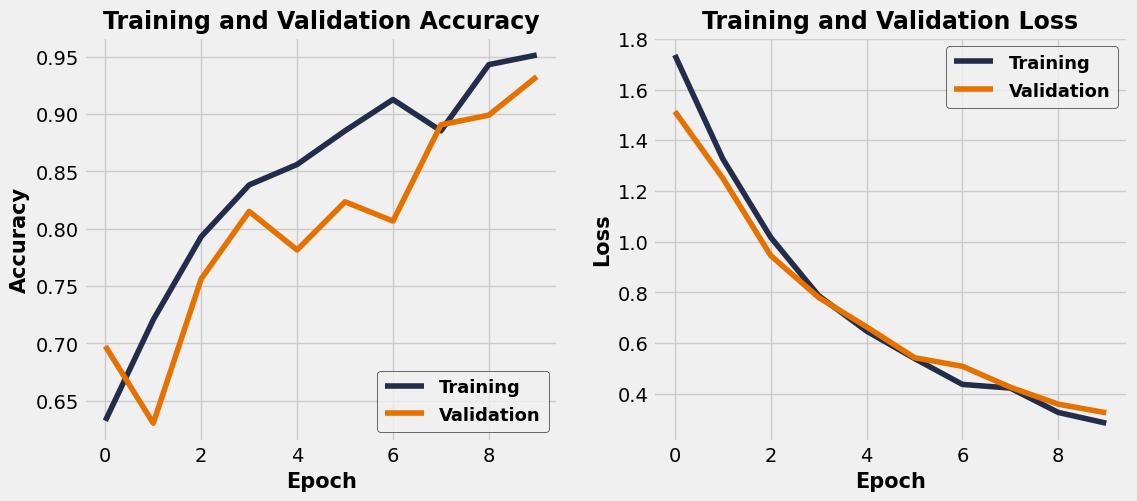

In [18]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs_range = range(10)

plot_training_history(acc2, val_acc2, loss2, val_loss2, epochs_range)

In [19]:
# Predict probs for positive class
y_pred_prob2 = model2.predict(X_test)

# AUC-ROC score
auc_roc2 = roc_auc_score(y_test, y_pred_prob2)

# Convert probs to class labels
y_pred_class2 = (y_pred_prob2 > 0.5).astype(int)

# F1-score
f12 = f1_score(y_test, y_pred_class2)

print("AUC-ROC Score:", auc_roc2)
print("F1-Score:", f12)

4/4 [==============================] - 0s 3ms/step
AUC-ROC Score: 0.9508522727272728
F1-Score: 0.9285714285714285


---

# Transformer (BERT)

In [21]:
# Load and preprocess the data
df = pd.read_csv('Speeches_War_Clean.csv')
df = df.drop(columns=['President', 'Date', 'Party'])

# Tokenize text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode text data
max_length = 256  # Define maximum sequence length
input_ids = []
attention_masks = []

for speech in df['Transcript']:
    encoded_dict = tokenizer.encode_plus(
                        speech,                         # Sentence to encode.
                        add_special_tokens=True,        # Add '[CLS]' and '[SEP]'
                        max_length=max_length,          # Pad & truncate all sentences.
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,     # Construct attn. masks.
                        return_tensors='tf',            # Return TensorFlow tensors.
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)
labels = df['War'].values

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# Combine input IDs and attention masks into a single feature matrix
features = tf.concat([input_ids, attention_masks], axis=1)

# Apply SMOTE and undersampling to the combined features
smote = SMOTE(sampling_strategy=0.6, random_state=28)
undersample = RandomUnderSampler(sampling_strategy=0.8, random_state=28)

features_resampled, labels_resampled = smote.fit_resample(features,
                                                          labels)

features_resampled, labels_resampled = undersample.fit_resample(features_resampled,
                                                                labels_resampled)

# Split the resampled data into train, validation, and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features_resampled,
                                                                            labels_resampled,
                                                                            test_size=0.3,
                                                                            random_state=28)

val_features, test_features, val_labels, test_labels = train_test_split(test_features,
                                                                        test_labels,
                                                                        test_size=0.5,
                                                                        random_state=28)

# Separate input IDs and attention masks
train_input_ids = train_features[:, :max_length]
train_attention_masks = train_features[:, max_length:]
val_input_ids = val_features[:, :max_length]
val_attention_masks = val_features[:, max_length:]
test_input_ids = test_features[:, :max_length]
test_attention_masks = test_features[:, max_length:]

# Convert tensors to arrays
train_input_ids_np = train_input_ids
train_attention_masks_np = train_attention_masks
val_input_ids_np = val_input_ids
val_attention_masks_np = val_attention_masks
test_input_ids_np = test_input_ids
test_attention_masks_np = test_attention_masks

In [23]:
# Calculate value counts for train, val, and test sets
train_value_counts = np.bincount(train_labels)
val_value_counts = np.bincount(val_labels)
test_value_counts = np.bincount(test_labels)

# Print the value counts for each class
print("Train Set:")
for i, count in enumerate(train_value_counts):
    print(f"Class {i}: {count} samples")

print("\nValidation Set:")
for i, count in enumerate(val_value_counts):
    print(f"Class {i}: {count} samples")

print("\nTest Set:")
for i, count in enumerate(test_value_counts):
    print(f"Class {i}: {count} samples")

Train Set:
Class 0: 456 samples
Class 1: 377 samples

Validation Set:
Class 0: 108 samples
Class 1: 70 samples

Test Set:
Class 0: 97 samples
Class 1: 82 samples


In [24]:
# Convert labels to one-hot encoding
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels, num_classes=2)
val_labels_one_hot = tf.keras.utils.to_categorical(val_labels, num_classes=2)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=2)

In [25]:
# Load pre-trained BERT model for sequence classification
bert = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# opt = 'adam'
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# metric = tf.keras.metrics.BinaryAccuracy()

bert.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Train the model
history_bert = bert.fit(
    [train_input_ids_np, train_attention_masks_np], train_labels_one_hot,
    validation_data=([val_input_ids_np, val_attention_masks_np], val_labels_one_hot),
    epochs=10,
    batch_size=32
)

Epoch 1/10
27/27 [==============================] - 110s 2s/step - loss: 7.5582 - accuracy: 0.4598 - val_loss: 7.7125 - val_accuracy: 0.3933
Epoch 2/10
27/27 [==============================] - 44s 2s/step - loss: 6.9459 - accuracy: 0.5330 - val_loss: 6.0314 - val_accuracy: 0.6067
Epoch 3/10
27/27 [==============================] - 43s 2s/step - loss: 6.9413 - accuracy: 0.5474 - val_loss: 6.0314 - val_accuracy: 0.6067
Epoch 4/10
27/27 [==============================] - 43s 2s/step - loss: 6.9413 - accuracy: 0.5474 - val_loss: 6.0314 - val_accuracy: 0.6067
Epoch 5/10
27/27 [==============================] - 43s 2s/step - loss: 6.9413 - accuracy: 0.5474 - val_loss: 6.0314 - val_accuracy: 0.6067
Epoch 6/10
27/27 [==============================] - 44s 2s/step - loss: 6.9413 - accuracy: 0.5474 - val_loss: 6.0314 - val_accuracy: 0.6067
Epoch 7/10
27/27 [==============================] - 43s 2s/step - loss: 6.9413 - accuracy: 0.5474 - val_loss: 6.0314 - val_accuracy: 0.6067
Epoch 8/10
27/27 [=

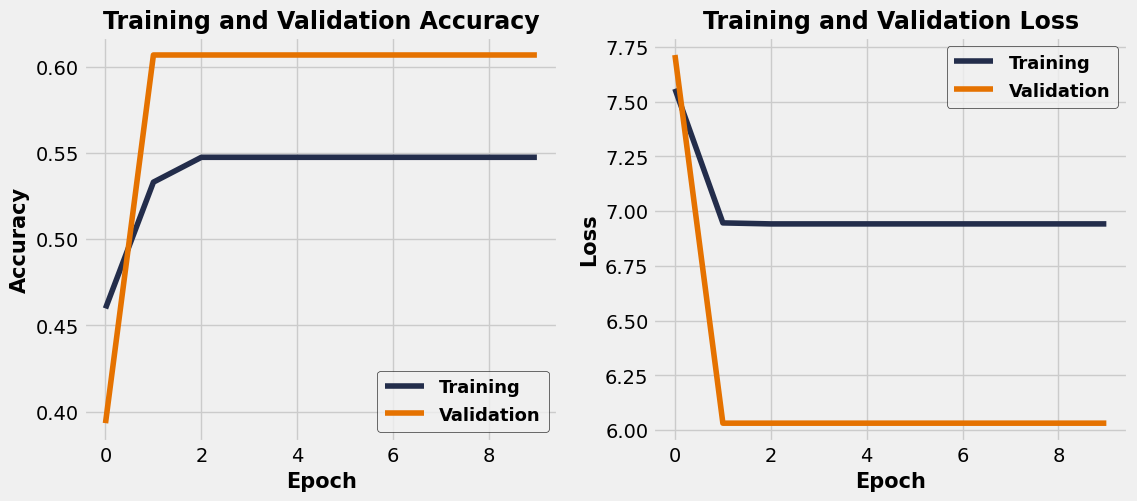

In [33]:
acc_bert = history_bert.history['accuracy']
val_acc_bert = history_bert.history['val_accuracy']

loss_bert = history_bert.history['loss']
val_loss_bert = history_bert.history['val_loss']

epochs_range = range(10)

plot_training_history(acc_bert, val_acc_bert, loss_bert, val_loss_bert, epochs_range)

In [34]:
# Predict probabilities on the test set
y_pred_probs = bert.predict([test_input_ids_np, test_attention_masks_np])

# Extract probabilities from the TFSequenceClassifierOutput object
y_pred_probs = y_pred_probs[0]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_binary = (y_pred_probs[:, 1] > 0.5).astype(int)

# Compute F1-score
f1 = f1_score(test_labels, y_pred_binary)
print(f"Test F1-Score: {f1}")

6/6 [==============================] - 11s 495ms/step
Test F1-Score: 0.0


In [35]:
# Calculate AUC-ROC
auc_roc = roc_auc_score(test_labels, y_pred_probs[:, 1])
print(f"Test AUC-ROC: {auc_roc}")

Test AUC-ROC: 0.502514458134272


---

# Interpretable Learning:

Now we try to identify discriminative features between the two classes (i.e., Interpretable Learning). That is, we want to see if we can answer questions like: What are the models seeing in the data that makes them classify observations as leading up to war or what is missing in the other class that makes the models classify that way?

We try several ways to add interpretability to our results, including:


### __1__: Attention Mechanisms:

We incorporate attention mechanisms into the second model architecture. Attention mechanisms can highlight which parts of the input sequence are most relevant for making predictions, providing interpretability at the token level.

### __2__: [Local Interpretable Modeling-agnostic Explanation (LIME)](https://github.com/marcotcr/lime):

The LIME package offers a principled approach to enhance the interpretability of ML models, including deep neural networks, by providing localized explanations for individual predictions. By generating locally perturbed datasets around instances of interest and fitting interpretable surrogate models, typically locally weighted linear regressions, LIME approximates the complex network behavior with simpler models. Through the examination of feature importance in these surrogate models, LIME elucidates the factors influencing predictions, aiding in the identification of key features and their impact on model outputs.

---

### __1__: Attention Mechanisms:


Since we use an LSTM model, attention mechanisms can be useful to understand which parts of the input sequences are most relevant for classification.

Here's how we implement attention mechanisms with our LSTM model:

- Define an Attention Layer: Define a custom attention layer that calculates attention weights based on the LSTM output.

- Modify the Model: Modify the existing model to incorporate the attention layer.

- Analyze Attention Weights: Analyze the attention weights to understand which parts of the input sequences are important for classification.

In [8]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = tf.matmul(x, self.W) + self.b
        at = tf.nn.softmax(et, axis=1)
        output = x * at
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [11]:
# Modify model2 to include attention layer
model3 = Sequential([
    Input(shape=input_shape),
    tf.keras.layers.Reshape(input_shape_with_timesteps),
    LSTM(128,
         activation='tanh',
         kernel_initializer='glorot_uniform',
         recurrent_initializer='orthogonal',
         dropout=0.1,
         recurrent_dropout=0.1,
         return_sequences=True),
    AttentionLayer(),  # Add attention layer
    Dense(64,
          activation='relu',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(1,
          activation='sigmoid',
          kernel_initializer='he_normal',
          kernel_regularizer=keras.regularizers.l2(0.01))
])

In [12]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrap  (None, 1, 768)            0         
 per)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            459264    
                                                                 
 attention_layer (Attention  (None, 128)               129       
 Layer)                                                          
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [13]:
# Compile and train the model as before
opt = Adam(learning_rate=0.001)

# Compile the model
model3.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
# Train the model
history3 = model3.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
30/30 [==============================] - 6s 21ms/step - loss: 1.7418 - accuracy: 0.5767 - val_loss: 1.5048 - val_accuracy: 0.6387
Epoch 2/10
30/30 [==============================] - 0s 8ms/step - loss: 1.3380 - accuracy: 0.6933 - val_loss: 1.1719 - val_accuracy: 0.7227
Epoch 3/10
30/30 [==============================] - 0s 8ms/step - loss: 1.0349 - accuracy: 0.7689 - val_loss: 0.9252 - val_accuracy: 0.7647
Epoch 4/10
30/30 [==============================] - 0s 8ms/step - loss: 0.7807 - accuracy: 0.8277 - val_loss: 0.7176 - val_accuracy: 0.8151
Epoch 5/10
30/30 [==============================] - 0s 8ms/step - loss: 0.6143 - accuracy: 0.8761 - val_loss: 0.5893 - val_accuracy: 0.8319
Epoch 6/10
30/30 [==============================] - 0s 8ms/step - loss: 0.4986 - accuracy: 0.8929 - val_loss: 0.4922 - val_accuracy: 0.8487
Epoch 7/10
30/30 [==============================] - 0s 8ms/step - loss: 0.4032 - accuracy: 0.9286 - val_loss: 0.4064 - val_accuracy: 0.8992
Epoch 8/10
30/30 [=

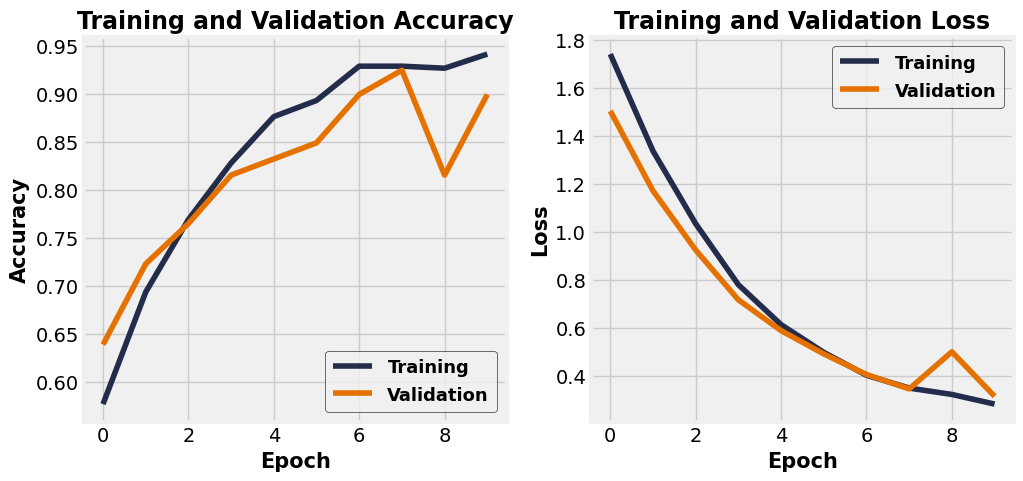

In [15]:
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs_range = range(10)

plot_training_history(acc3, val_acc3, loss3, val_loss3, epochs_range)

In [16]:
# Predict probs for positive class
y_pred_prob3 = model3.predict(X_test)

# AUC-ROC score
auc_roc3 = roc_auc_score(y_test, y_pred_prob3)

# Convert probs to class labels
y_pred_class3 = (y_pred_prob3 > 0.5).astype(int)

# F1-score
f13 = f1_score(y_test, y_pred_class3)

print("AUC-ROC Score:", auc_roc3)
print("F1-Score:", f13)

4/4 [==============================] - 0s 3ms/step
AUC-ROC Score: 0.9534090909090909
F1-Score: 0.9090909090909091


After defining `model3`, we create another model, `attention_model`, using the Model class, specifying the same inputs as model3 but setting the output to that of the attention layer. This allows us to extract the attention weights, providing insights into how the attention mechanism is weighting different parts of the input sequence.

In [17]:
# Analyze Attention Weights
attention_model = Model(inputs=model3.input, outputs=model3.layers[4].output)
attention_weights = attention_model.predict(X_train)

30/30 [==============================] - 0s 2ms/step


In [35]:
# Calculate summary statistics of attention weights for each class
mean_attention_wt_class_0 = np.mean(attention_weights[y_train == 0], axis=1)
mean_attention_wt_class_1 = np.mean(attention_weights[y_train == 1], axis=1)

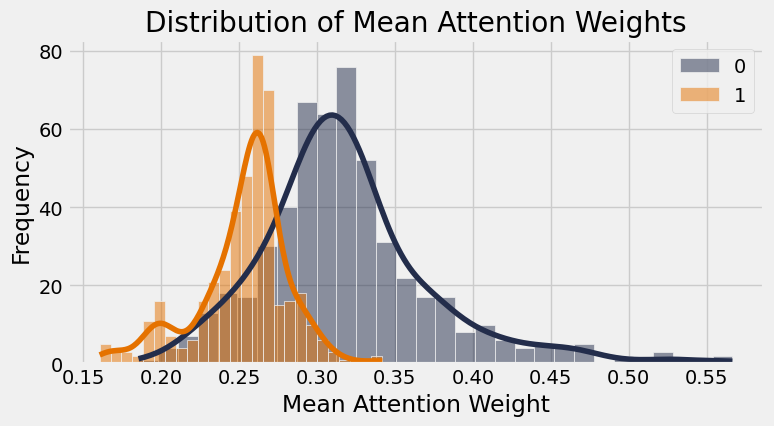

In [19]:
plt.figure(figsize=(8, 4))
plt.style.use('fivethirtyeight')
sns.histplot(mean_attention_wt_class_0, color='#232D4B', label='0', kde=True)
sns.histplot(mean_attention_wt_class_1, color='#E57200', label='1', kde=True)
plt.title('Distribution of Mean Attention Weights')
plt.xlabel('Mean Attention Weight')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [20]:
# Perform statistical tests to compare attention weights between classes
t_stat, p_value = ttest_ind(mean_attention_wt_class_0, mean_attention_wt_class_1)
print(f"T-Statistic: {t_stat}, p-value: {p_value}")

T-Statistic: 22.18356237224604, p-value: 3.467135785911413e-88


---

### __2__: LIME

In [25]:
# create wrapper function
def predict_fn(X):
    pred = model2.predict(X)
    return np.hstack([1-pred, pred])

In [26]:
X_column_names = X_train_df.columns.tolist()

In [27]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train,
    feature_names = X_column_names,
    class_names = ['Non-War', 'War'],
    mode = "classification"
)

In [28]:
# Explain an individual prediction:
X_train.shape[1:]
X_sample = X_train[0].reshape(1, -1)

exp = explainer.explain_instance(
    data_row = X_sample.flatten(),
    predict_fn = predict_fn
)

157/157 [==============================] - 1s 2ms/step


In [29]:
# Visualize
exp.show_in_notebook(show_table = True, show_all = False)

---